# Imbonga-Gruppe

In [1]:
%matplotlib inline
from IPython.display import display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import sqlite3

import sys, os
sys.path.append("/Python")
from myfunctions import *
from parula import *

style = 'IMB'

con = sqlite3.connect("../data/CongoDB.sqlite")

## Funde

In [30]:
sql = """SELECT
           t_Obj.objID,
           t_Ort.ort_kurz,
           't_Ort'.'ort_name' || ' (Fpl. ' || 't_ort'.'Kat-Nr' || ')' AS Ort,
           t_Komplex.bef_nr,
           t_komplex.bef_art,
           t_Ort.ort_fluss,
           t_Obj.GefEinheit AS GE,
           t_Obj.Scherbe,
           t_Obj.Gewicht,
           t_Obj.Anzahl,
           t_Obj.Typ
       FROM (t_Ort INNER JOIN t_Komplex ON t_Ort.ortID = t_Komplex.ortID)
           INNER JOIN t_Obj ON t_Komplex.komplexID = t_Obj.komplexID
       WHERE (((t_Ort.ort_lit)='DS')
           AND ((t_Obj.Typ) Like '%"""+style+"""%')
           AND ((t_Obj.Art) = 'K')
           AND ((t_Obj.Anzahl) != ''))""".replace('\n',' ')
# Anzahl != damit fotografierte Gefäße nicht mit dabei ist

df = pd.read_sql(sql, con)
# display(df.head())

In [31]:
df.pivot_table(values = 'objID', index = 'Typ', aggfunc = len, margins = True)

Typ
IMB             4.0
IMB (?)         4.0
IMB/BDG (?)     1.0
PKM/IMB (?)     2.0
All            11.0
Name: objID, dtype: float64

In [32]:
a = pd.Series({'sicher':len(df.loc[~df['Typ'].str.contains("/| ")].index),
               'fraglich':len(df.loc[df['Typ'].str.contains("/| ")].index)})
a = pd.DataFrame(a)
a['Prozent'] = a[0]/a[0].sum()*100
a

,0,Prozent
fraglich,7,63.636364
sicher,4,36.363636


In [6]:
df.pivot_table(values = 'Anzahl', index = ['ort_fluss', 'Ort', 'bef_nr'], columns='Typ', aggfunc = np.sum)

Typ                                      IMB  IMB (?)  IMB/BDG (?)  \
ort_fluss   Ort                  bef_nr                              
Sangha      Bokonongo (Fpl. 250) 87/102  NaN      1.0          NaN   
            Ifondo (Fpl. 253)    87/101  NaN      1.0          NaN   
            Mitula (Fpl. 251)    87/101  1.0      1.0          NaN   
                                 87/103  1.0      NaN          NaN   
            Mobaka (Fpl. 246)    87/102  1.0      NaN          NaN   
Zaire/Kongo Gombe (Fpl. 237)     87/101  1.0      1.0          1.0   

Typ                                      PKM/IMB (?)  
ort_fluss   Ort                  bef_nr               
Sangha      Bokonongo (Fpl. 250) 87/102          NaN  
            Ifondo (Fpl. 253)    87/101          2.0  
            Mitula (Fpl. 251)    87/101          NaN  
                                 87/103          NaN  
            Mobaka (Fpl. 246)    87/102          NaN  
Zaire/Kongo Gombe (Fpl. 237)     87/101          NaN

In [5]:
df_pivot = df.pivot_table(values = ['Anzahl', 'Gewicht'], index = ['ort_fluss', 'Ort', 'bef_nr'], aggfunc = np.sum)
df_pivot = pd.DataFrame(df_pivot)
df_pivot['%'] = df_pivot['Anzahl']/df_pivot['Anzahl'].sum()*100
df_pivot['Gew.-%'] = df_pivot['Gewicht']/df_pivot['Gewicht'].sum()*100
df_pivot

Anzahl  Gewicht          %     Gew.-%
ort_fluss   Ort                  bef_nr                                       
Sangha      Bokonongo (Fpl. 250) 87/102       1       36   9.090909   6.304729
            Ifondo (Fpl. 253)    87/101       3       56  27.272727   9.807356
            Mitula (Fpl. 251)    87/101       2       86  18.181818  15.061296
                                 87/103       1       93   9.090909  16.287215
            Mobaka (Fpl. 246)    87/102       1      179   9.090909  31.348511
Zaire/Kongo Gombe (Fpl. 237)     87/101       3      121  27.272727  21.190893

In [23]:
# Anzahl Stücke
np.sum(df_pivot['Anzahl'])

11

In [24]:
# Gewicht insg. in kg
np.sum(df_pivot['Gewicht']) / 1000

0.571

In [25]:
df_pivot = df.pivot_table(values = ['Anzahl', 'Gewicht'], index = ['bef_art'], aggfunc = np.sum)
df_pivot = pd.DataFrame(df_pivot)
df_pivot['%'] = df_pivot['Anzahl']/df_pivot['Anzahl'].sum()*100
df_pivot['Gew.-%'] = df_pivot['Gewicht']/df_pivot['Gewicht'].sum()*100
df_pivot

,Anzahl,Gewicht,%,Gew.-%
bef_art,,,,
Grube,1,93,9.090909,16.287215
Grube (?),1,179,9.090909,31.348511
Oberfl,9,299,81.818182,52.364273


## Scherbentypen

In [26]:
df_pivot = df.pivot_table(values = 'Anzahl', index = 'Scherbe', aggfunc = np.sum)
df_pivot['B'] = 0.
custom_dict = {'G':0,'R':1,'W':3,'B':4}
df_pivot = pd.DataFrame(df_pivot, index=sorted(custom_dict, key=custom_dict.get))
df_pivot['Prozent'] = df_pivot['Anzahl']/df_pivot['Anzahl'].sum()*100
df_pivot

,Anzahl,Prozent
G,NaN,NaN
R,NaN,NaN
W,10.0,100.0
B,0.0,0.0


## Fragmentierung

C:\Users\Dirk\Anaconda3\lib\site-packages\ipykernel\__main__.py:18: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


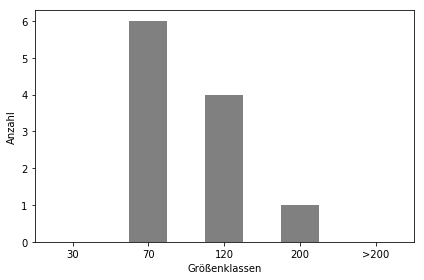

In [28]:
sql = """SELECT
           t_Obj.objID, 
           t_Komplex.bef_nr, 
           t_Obj.Komplex, 
           t_Obj.Gewicht,
           t_Obj.Gr_Clist, 
           t_Obj.Art,
           t_Obj.Tiefe 
       FROM (t_Ort INNER JOIN t_Komplex ON t_Ort.ortID = t_Komplex.ortID)
           INNER JOIN t_Obj ON t_Komplex.komplexID = t_Obj.komplexID
       WHERE (((t_Ort.ort_lit)='DS')
           AND ((t_Obj.Typ) Like '%"""+style+"""%')
           AND ((t_Obj.Art) = 'K')
           AND ((t_Obj.Anzahl) != '')
           AND ((t_Obj.Gr_Clist) != ''))""".replace('\n',' ')

df = pd.read_sql(sql, con)
df['Tiefe'] = df['Tiefe'].convert_objects(convert_numeric=True)
# Leerstellen in 'Typ' ersetzen
# df['Typ'] = df['Typ'].replace('','(?)')
# df['Tiefe'] = df['Tiefe'].replace('', np.nan) 
# df = df.dropna(subset=['Tiefe'])
# display(df.head())

df_pivot = df.pivot_table(values = 'objID', index = 'Gr_Clist', aggfunc = len)
custom_dict = {30:30, 70:70, 120:120, 200:200, 500:500}
df_pivot = pd.DataFrame(df_pivot, index=sorted(custom_dict, key=custom_dict.get))
df_pivot = df_pivot.rename(index={500: '>200'})

df_pivot = pd.DataFrame(df_pivot)
df_pivot['%'] = df_pivot['objID']/df_pivot['objID'].sum()*100

df_pivot['objID'].plot(kind = 'bar', color = 'grey')
plt.xticks(rotation=0)
plt.xlabel('Größenklassen')
plt.ylabel('Anzahl')
plt.tight_layout()
#plt.savefig('../output/figs/9-12_MUN87-1_KeramikFragmentierung.pdf')
plt.show()

In [29]:
df_pivot

,objID,%
30,NaN,NaN
70,6.0,54.545455
120,4.0,36.363636
200,1.0,9.090909
>200,NaN,NaN


## Technologische Merkmale (*fabrics*)

In [30]:
sql = """SELECT
           t_Obj.objID,
           't_Ort'.'ort_name' || ' (Fpl. ' || 't_ort'.'Kat-Nr' || ')' AS Ort,
           t_Obj.Anzahl,
           t_Obj.MagerungGröße,
           t_Obj.MagerungArt,
           t_Obj.MagerungDichte,
           t_Obj.Fabric
       FROM (t_Ort INNER JOIN t_Komplex ON t_Ort.ortID = t_Komplex.ortID)
           INNER JOIN t_Obj ON t_Komplex.komplexID = t_Obj.komplexID
       WHERE (((t_Obj.Fabric) != '')
           AND ((t_Obj.Typ) Like '%"""+style+"""%'))""".replace('\n',' ')

df = pd.read_sql(sql, con)

In [31]:
df_pivot = df.pivot_table(values = 'Anzahl', index = 'Fabric', aggfunc = sum)
df_pivot = pd.DataFrame(df_pivot)
df_pivot = df_pivot.sort_index(by=['Anzahl'], ascending=[False])

C:\Users\Dirk\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: FutureWarning: by argument to sort_index is deprecated, pls use .sort_values(by=...)
  app.launch_new_instance()


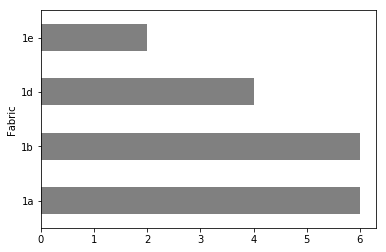

In [32]:
df_pivot.plot(kind = 'barh', legend = False, color = 'Grey')
plt.show()

In [34]:
df1 = df.dropna(subset = ['Fabric'])
df1['Fabric'] = df1['Fabric'].map(lambda x: x.rstrip(' (?)'))
df1['Fabric'] = df1['Fabric'].apply(lambda x: x.split('/')[0])\

a = df1.pivot_table(values = 'Anzahl', index = 'Fabric', aggfunc = sum)
a = pd.DataFrame(a)
a = a.sort_index(by=['Anzahl'], ascending=[False])

a = pd.Series({'1':sum(df1["Anzahl"].loc[df1["Fabric"].str.contains("1")]),
               '2':sum(df1["Anzahl"].loc[df1["Fabric"].str.contains("2")]),
               '3':sum(df1["Anzahl"].loc[df1["Fabric"].str.contains("3")]),
               '4':sum(df1["Anzahl"].loc[df1["Fabric"].str.contains("4")]),
               '5':sum(df1["Anzahl"].loc[df1["Fabric"].str.contains("5")]),
               '6':sum(df1["Anzahl"].loc[df1["Fabric"].str.contains("6")]),
               '7':sum(df1["Anzahl"].loc[df1["Fabric"].str.contains("7")]),
               '8':sum(df1["Anzahl"].loc[df1["Fabric"].str.contains("8")]),
               '9':sum(df1["Anzahl"].loc[df1["Fabric"].str.contains("9")])})
a = pd.DataFrame(a)
a['Prozent'] = a[0]/a[0].sum()*100
a

C:\Users\Dirk\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: FutureWarning: by argument to sort_index is deprecated, pls use .sort_values(by=...)


,0,Prozent
1,18,100.0
2,0,0.0
3,0,0.0
4,0,0.0
5,0,0.0
6,0,0.0
7,0,0.0
8,0,0.0
9,0,0.0


In [35]:
df = df.replace('<1','sehr wenig', regex=True)

a = df.loc[df['MagerungDichte'] != ''] # nur Einträgen, bei denen diese Felder ausgefüllt sind
df_pivot = a.pivot_table(values = 'Anzahl', index = 'MagerungDichte', aggfunc = sum)
custom_dict = {'sehr wenig':0,'wenig':1,'mittel':3,'viel':4, 'sehr viel':5}
df_pivot = pd.DataFrame(df_pivot, index=sorted(custom_dict, key=custom_dict.get))
df_pivot['Prozent'] = df_pivot['Anzahl']/df_pivot['Anzahl'].sum()*100
df_pivot

,Anzahl,Prozent
sehr wenig,15.0,93.75
wenig,1.0,6.25
mittel,NaN,NaN
viel,NaN,NaN
sehr viel,NaN,NaN


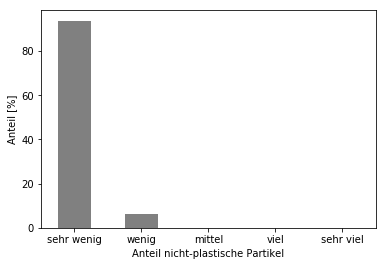

In [36]:
df_pivot.plot(y = 'Prozent', kind = 'bar', legend = None, color = 'grey')
plt.xticks(rotation=0)
plt.xlabel('Anteil nicht-plastische Partikel')
plt.ylabel('Anteil [%]')
plt.show()

In [37]:
df_pivot = a.pivot_table(values = 'Anzahl', index = 'MagerungGröße', aggfunc = sum)
custom_dict = {'VF':0,'F':1,'M':3,'C':4, 'VC':5}
df_pivot = pd.DataFrame(df_pivot, index=sorted(custom_dict, key=custom_dict.get))
df_pivot['Prozent'] = df_pivot['Anzahl']/df_pivot['Anzahl'].sum()*100
df_pivot

,Anzahl,Prozent
VF,10.0,62.5
F,4.0,25.0
M,2.0,12.5
C,NaN,NaN
VC,NaN,NaN


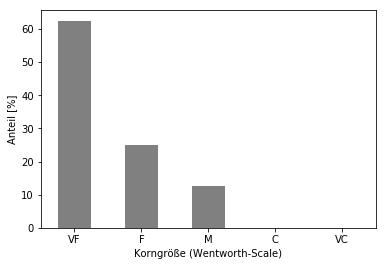

In [38]:
df_pivot.plot(y = 'Prozent', kind = 'bar', legend = None, color = 'grey')
plt.xticks(rotation=0)
plt.xlabel('Korngröße (Wentworth-Scale)')
plt.ylabel('Anteil [%]')
plt.show()

In [39]:
df_pivot = a.pivot_table(values = 'Anzahl', index = 'MagerungArt', aggfunc = sum)
df_pivot = pd.DataFrame(df_pivot)
df_pivot = df_pivot.sort_index(by=['Anzahl'], ascending=[False])
df_pivot['Prozent'] = df_pivot['Anzahl']/df_pivot['Anzahl'].sum()*100
df_pivot

C:\Users\Dirk\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: FutureWarning: by argument to sort_index is deprecated, pls use .sort_values(by=...)
  app.launch_new_instance()


,Anzahl,Prozent
MagerungArt,,
S,11,68.75
,5,31.25


## Brennfarbe

In [7]:
sql = """SELECT
           t_Obj.objID,
           [t_Obj].[Außenfarbe] || '/' || [t_Obj].[Prof_aussen] || '/' || [t_Obj].[Prof_Kern] || '/' || [t_Obj].[Prof_innen] || '/' || [t_Obj].[Innenfarbe] AS Farbe
       FROM (t_Ort LEFT JOIN t_Komplex ON t_Ort.ortID = t_Komplex.ortID)
           LEFT JOIN t_Obj ON t_Komplex.komplexID = t_Obj.komplexID
       WHERE (((t_Obj.Fabric) != '')
           AND ((t_Obj.Typ) Like '%"""+style+"""%'))""".replace('\n',' ')
df = pd.read_sql(sql, con)

a = pd.Series({'Weiß':len(df[df['Farbe'].str.contains("W")].index),
               'Rot':len(df[df['Farbe'].str.contains("R")].index),
               'Sonstig':len(df[~df['Farbe'].str.contains("W|R")].index)})
a = pd.DataFrame(a)
a['Prozent'] = a[0]/a[0].sum()*100
a

,0,Prozent
Rot,0,0.000000
Sonstig,7,38.888889
Weiß,11,61.111111


## Oberfläche der Scherben

In [8]:
sql = """SELECT
           t_Obj.objID,
           t_Obj.Anzahl,
           t_Obj.Obfl,
           t_Obj.Fabric
       FROM (t_Ort INNER JOIN t_Komplex ON t_Ort.ortID = t_Komplex.ortID)
           INNER JOIN t_Obj ON t_Komplex.komplexID = t_Obj.komplexID
       WHERE (((t_Obj.Obfl) != '')
           AND ((t_Obj.Typ) LIKE '%"""+style+"""%'))""".replace('\n',' ')

df = pd.read_sql(sql, con)

df['Anzahl'] = df['Anzahl'].convert_objects(convert_numeric=True)
df_pivot = df.pivot_table(values = 'Anzahl', index = 'Obfl', aggfunc = sum)
df_pivot = pd.DataFrame(df_pivot)
df_pivot['Prozent'] = df_pivot['Anzahl']/df_pivot['Anzahl'].sum()*100
df_pivot

C:\Users\Dirk\Anaconda3\lib\site-packages\ipykernel\__main__.py:13: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


,Anzahl,Prozent
Obfl,,
glatt,10,90.909091
leicht rau,1,9.090909


## Wandungsdicke

C:\Users\Dirk\Anaconda3\lib\site-packages\ipykernel\__main__.py:11: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


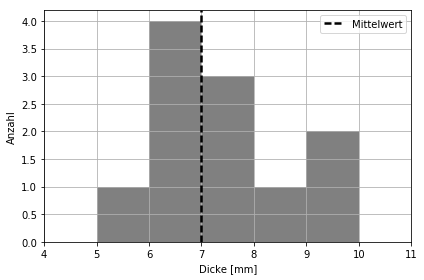

In [9]:
sql = """SELECT
           t_Obj.objID,
           t_Obj.Wandung 
       FROM (t_Ort INNER JOIN t_Komplex ON t_Ort.ortID = t_Komplex.ortID)
           INNER JOIN t_Obj ON t_Komplex.komplexID = t_Obj.komplexID
       WHERE (((t_Obj.Obfl) != '')
           AND ((t_Obj.Typ) LIKE '%"""+style+"""%'))""".replace('\n',' ')

df = pd.read_sql(sql, con)

df['Wandung'] = df['Wandung'].convert_objects(convert_numeric=True)

# Spannweite ermitteln und als bins nutzen
bins = df['Wandung'].max() - df['Wandung'].min()

mean = df['Wandung'].mean()

df['Wandung'].hist(bins = bins, color = 'grey', histtype='stepfilled')
plt.axvline(mean, color = 'black', ls = 'dashed', lw = 2.5)
plt.xlabel("Dicke [mm]")
plt.ylabel("Anzahl")
plt.xlim([df['Wandung'].min()-1,df['Wandung'].max()+1])
legend = plt.legend(["Mittelwert"])
legend.get_frame().set_facecolor('white')
plt.tight_layout()

In [10]:
df['Wandung'].describe()

count    11.00000
mean      7.00000
std       1.48324
min       5.00000
25%       6.00000
50%       7.00000
75%       7.50000
max      10.00000
Name: Wandung, dtype: float64

In [11]:
np.var(df['Wandung'])

2.0

## Gefäßformen

In [38]:
sql = """SELECT
           t_Ort.ort_kurz,
           t_Ort.ort_name,
           t_Obj.objID,
           t_Obj.Typ,
           t_Obj.Form_Gef
       FROM (t_Ort INNER JOIN t_Komplex ON t_Ort.ortID = t_Komplex.ortID)
           INNER JOIN t_Obj ON t_Komplex.komplexID = t_Obj.komplexID
       WHERE (((t_Ort.ort_lit)='DS')
           AND ((t_Obj.Typ) Like '%"""+style+"""%')
           AND ((t_Obj.Form_Gef) != ''))""".replace('\n',' ')

df = pd.read_sql(sql, con)
# display(df.head())

In [39]:
df_pivot = df.pivot_table(values = 'objID', index = 'Form_Gef', aggfunc = len)
df_pivot = pd.DataFrame(df_pivot)
df_pivot = df_pivot.sort_index(by = ['objID'], ascending = True)
# display(df_pivot.head())

C:\Users\Dirk\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: FutureWarning: by argument to sort_index is deprecated, pls use .sort_values(by=...)
  app.launch_new_instance()


In [40]:
df_pivot['objID'].sum()

5

In [42]:
df_pivot['GefForm'] = df_pivot.index
a = pd.Series({'sicher':sum(df_pivot['objID'].loc[~df_pivot['GefForm'].str.contains(" |/")]),
               'fraglich':sum(df_pivot['objID'].loc[df_pivot['GefForm'].str.contains(" |/")])})
a = pd.DataFrame(a)
a['Prozent'] = a[0]/a[0].sum()*100
a

,0,Prozent
fraglich,4,80.0
sicher,1,20.0


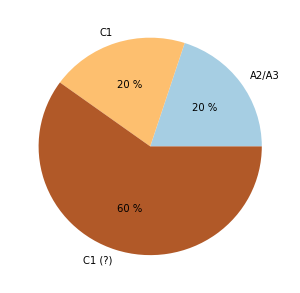

In [43]:
fig = plt.figure()
fig.set_size_inches(5, 5)
df_pivot['objID'].plot(kind='pie', autopct='%.0f %%', cmap = 'Paired')
plt.ylabel('')

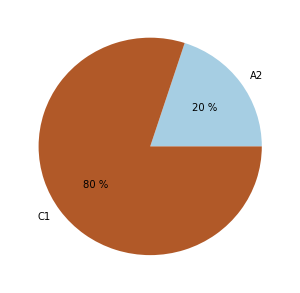

In [17]:
df1 = df.dropna(subset = ['Form_Gef'])
df1['Form_Gef'] = df1['Form_Gef'].map(lambda x: x.rstrip(' (?)'))
df1['Form_Gef'] = df1['Form_Gef'].apply(lambda x: x.split('/')[0])

df_pivot = df1.pivot_table(values = 'objID', index = 'Form_Gef', aggfunc = len)
df_pivot = pd.DataFrame(df_pivot)

fig = plt.figure()
fig.set_size_inches(5, 5)
df_pivot['objID'].plot(kind='pie', autopct='%.0f %%', cmap = 'Paired')
plt.ylabel('')

In [19]:
sql = """SELECT
           t_Ort.ort_kurz,
           t_Ort.ort_name,
           t_Obj.objID,
           t_Obj.Typ,
           t_Obj.Form_Gef,
           t_Obj.Form_Mdg,
           t_Obj.Form_Rand,
           t_Obj.Form_Hals,
           t_Obj.Form_Schulter,
           t_Obj.Form_Boden
       FROM (t_Ort INNER JOIN t_Komplex ON t_Ort.ortID = t_Komplex.ortID)
           INNER JOIN t_Obj ON t_Komplex.komplexID = t_Obj.komplexID
       WHERE (((t_Ort.ort_lit)='DS')
           AND ((t_Obj.Typ) Like '%"""+style+"""%')
           AND ((t_Obj.Anzahl) = 1))""".replace('\n',' ')

df = pd.read_sql(sql, con)
# leere Werte in NaN ändern
df = df.replace('',np.nan, regex=True)
df

,ort_kurz,ort_name,objID,Typ,Form_Gef,Form_Mdg,Form_Rand,Form_Hals,Form_Schulter,Form_Boden
0,MKA,Mobaka,1245,IMB,C1 (?),NaN,None,NaN,A2,None
1,MIT,Mitula,1246,IMB,C1,NaN,None,NaN,A2,None
2,GMB,Gombe,1830,IMB/BDG (?),None,M1,B3,NaN,NaN,B12 (?)
3,IFN,Ifondo,1851,IMB (?),None,NaN,None,NaN,NaN,None
4,BOG,Bokonongo,2161,IMB (?),None,NaN,None,NaN,NaN,None
5,MIT,Mitula,4376,IMB (?),C1 (?),NaN,None,NaN,A2,None
6,MIT,Mitula,4377,IMB,C1 (?),NaN,None,B3,A2,None
7,IFN,Ifondo,4652,PKM/IMB (?),None,NaN,None,NaN,NaN,None
8,IFN,Ifondo,4653,PKM/IMB (?),None,NaN,None,NaN,NaN,None
9,GMB,Gombe,6299,IMB,A2/A3,NaN,None,A1/B1/lang,NaN,None


## Verzierungselemente

In [2]:
(df_pivotBig_perc, df_pivotBig_perc_a, new_cmap) = decoration_positon_matrices_print(style)

C:\Users\Dirk\Dropbox\Dissertation\Python\myfunctions.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df1['n'] = 1
C:\Users\Dirk\Dropbox\Dissertation\Python\myfunctions.py:88: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  ab[1] = ab[1].convert_objects(convert_numeric=True)


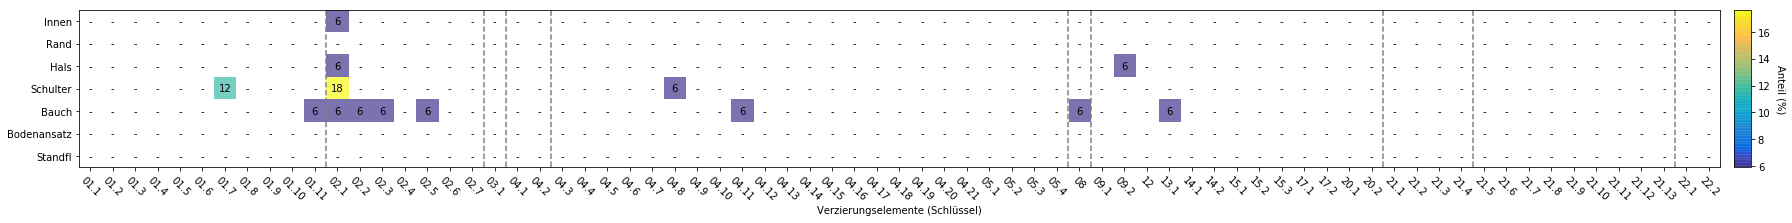

In [3]:
fig = plt.figure()
fig.set_size_inches(25, 15)

ax = plt.gca()
im = ax.imshow(df_pivotBig_perc, interpolation='nearest', cmap=parula_map, alpha=.66)

plt.xlabel('Verzierungselemente (Schlüssel)')
plt.yticks(range(len(df_pivotBig_perc.index)), df_pivotBig_perc.index.str[2:])
plt.xticks(range(len(df_pivotBig_perc.columns)), df_pivotBig_perc.columns, rotation = -45)

for (i, j), z in np.ndenumerate(df_pivotBig_perc_a):
    plt.text(j, i, z, ha='center', va='center')
    
plt.axvline(10.5, color='grey', linestyle = '--')
plt.axvline(17.5, color='grey', linestyle = '--')
plt.axvline(18.5, color='grey', linestyle = '--')
plt.axvline(20.5, color='grey', linestyle = '--')
plt.axvline(43.5, color='grey', linestyle = '--')
plt.axvline(44.5, color='grey', linestyle = '--')
plt.axvline(57.5, color='grey', linestyle = '--')
plt.axvline(61.5, color='grey', linestyle = '--')
plt.axvline(70.5, color='grey', linestyle = '--')

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="1%", pad=0.2)
cbar = plt.colorbar(im, cax=cax)
cbar.set_label('Anteil (%)', rotation = -90, labelpad = 15)

plt.tight_layout()

plt.savefig('../output/figs/3-2-1-1_Imbonga_VerzierungselmenteAlle.pdf', bbox_inches='tight')
plt.show()

In [44]:
sql = """SELECT
           t_Obj.objID,
           t_K_Pos.posID,
           t_K_Verz.verzID,
           [t_K_Pos].[posReihe] || ' ' || [posName] AS pos,
           t_K_Verz.verzName,
           t_K_Verz.verzName_alt,
           t_K_Verz.verzBeschr,
           t_Obj.Typ,
           t_Obj.Form_Gef
       FROM t_Obj INNER JOIN "t_ObjPosVerz" ON t_Obj.objID = "t_ObjPosVerz".objID
           INNER JOIN t_K_Pos ON "t_ObjPosVerz".posID = t_K_Pos.posID
           INNER JOIN t_K_Verz ON "t_ObjPosVerz".verzID = t_K_Verz.verzID
       WHERE (((t_K_Pos.posID)<>1)
           AND ((t_K_Verz.verzName) != '')
           AND ((t_Obj.Typ) Like '%"""+style+"""%'))""".replace('\n',' ')

df = pd.read_sql(sql, con)
# display(df.head())

In [45]:
df_pivot = df.pivot_table(values = 'objID', index = 'pos', columns = 'verzName', aggfunc = len)
df_pivot = df_pivot.fillna(0)
# Sortierung für graphische Darstellung umdrehen
df_pivot = df_pivot.sort_index(ascending=True)
# heatmap siehe http://yonatanfriedman.com/docs/survey/plotting.html

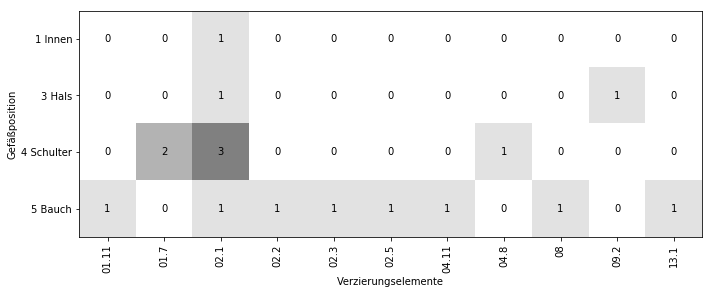

In [46]:
fig = plt.figure()
fig.set_size_inches(10, 7.5)
plt.imshow(df_pivot, interpolation='nearest', cmap='Greys', alpha = .5)
plt.ylabel('Gefäßposition')
plt.xlabel('Verzierungselemente')
plt.yticks(range(len(df_pivot.index)), df_pivot.index)
plt.xticks(range(len(df_pivot.columns)), df_pivot.columns, rotation='vertical')
# plt.colorbar(orientation='horizontal')
for (i, j), z in np.ndenumerate(df_pivot):
    plt.text(j, i, '{:0.0f}'.format(z), ha='center', va='center')
plt.tight_layout()
plt.savefig('../output/figs/3-1-2-8_Konda_Verzierungselmente.pdf', bbox_inches='tight')
plt.show()

In [47]:
df_pivot = df.pivot_table(values = 'objID', index = 'verzName', aggfunc = len)
df_pivot = pd.DataFrame(df_pivot)
# Sortierung in Aufsteigend ändern
df_pivot = df_pivot.sort_index(by = ['objID'], ascending = True)

C:\Users\Dirk\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: FutureWarning: by argument to sort_index is deprecated, pls use .sort_values(by=...)


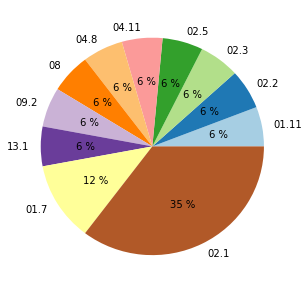

In [48]:
fig = plt.figure()
fig.set_size_inches(5, 5)
df_pivot['objID'].plot(kind='pie', autopct='%.0f %%', cmap = 'Paired' )
plt.ylabel('')

In [49]:
df_pivot = df.pivot_table(values = 'objID', index = 'pos', aggfunc = len)
df_pivot = pd.DataFrame(df_pivot)
# Sortierung in Aufsteigend ändern
df_pivot['Prozent'] = df_pivot["objID"]/df_pivot["objID"].sum()*100
df_pivot = df_pivot.sort_index(by = ['objID'], ascending = False)
df_pivot

C:\Users\Dirk\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: FutureWarning: by argument to sort_index is deprecated, pls use .sort_values(by=...)


,objID,Prozent
pos,,
5 Bauch,8,47.058824
4 Schulter,6,35.294118
3 Hals,2,11.764706
1 Innen,1,5.882353


In [67]:
df['verzTechnik'] = df['verzName'].str[:2]

df_pivot = df.pivot_table(values = 'objID', index = 'verzTechnik', aggfunc = len)
df_pivot = pd.DataFrame(df_pivot)
df_pivot['Prozent'] = df_pivot["objID"]/df_pivot["objID"].sum()*100
df_pivot = df_pivot.sort_index(by = ['objID'], ascending = False)
df_pivot

C:\Users\Dirk\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: FutureWarning: by argument to sort_index is deprecated, pls use .sort_values(by=...)


,objID,Prozent
verzTechnik,,
02,9,52.941176
01,3,17.647059
04,2,11.764706
08,1,5.882353
09,1,5.882353
13,1,5.882353


## Verbreitung

In [16]:
df = style_mapping_gis_export(style)
df.sort_values(['Kat-Nr'])

Typ,Ort,Kat-Nr,X,Y,TYP
0,Gombe (Fpl. 237),237,17.580406,-0.704069,IMB
2,Mobaka (Fpl. 246),246,17.134569,-0.366609,IMB
0,Bokonongo (Fpl. 250),250,17.129437,0.201971,IMB (?)
1,Mitula (Fpl. 251),251,17.046761,0.291662,IMB
2,Ifondo (Fpl. 253),253,16.908795,0.481301,IMB (?)


In [17]:
df.to_csv("../data/processed/3-2-1-1_IMB_Verbreitung.csv", index = False)

In [18]:
len(df)

5

> KARTIERUNG IN R UMGESETZT VIA GGMAP

---

Notiz für Kartierung:
1. Abfrage mit Typ Like '%Imb%?' (== nur mögliche/unsichere IMB)
2. Abfrage mit Typ = 'Imbonga' (== sichere IMB)

Kartierungen: zuerst 1. mit Kreissignatur (offen), dann darüber 2. mit ausgefüllter Pkt.-Signatur

In [10]:
sql = """SELECT
           t_Obj.objID,
           t_Ort.ort_kurz,
           t_Ort.ort_fluss,
           t_Ort.[Kat-Nr],
           [t_Ort].[ort_name] || ' (' || [Kat-Nr] ||')' AS ort,
           t_Komplex.bef_nr,
           t_Obj.Individuum,
           t_Obj.Typ,
           t_Ort.y_lat,
           t_Ort.x_long
       FROM (t_Ort INNER JOIN t_Komplex ON t_Ort.ortID = t_Komplex.ortID) 
           INNER JOIN t_Obj ON (t_Ort.ortID = t_Obj.ortID) 
           AND (t_Komplex.komplexID = t_Obj.komplexID)
       WHERE (((t_Ort.ort_lit)='DS') 
           AND ((t_Obj.Typ) Like '%Imb%'))""".replace('\n',' ')

df = pd.read_sql(sql, con)
df['y_lat'] = df['y_lat'].convert_objects(convert_numeric=True)
df['x_long'] = df['x_long'].convert_objects(convert_numeric=True)
display(df.head())

C:\Users\Dirk\Anaconda3\lib\site-packages\ipykernel\__main__.py:19: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
C:\Users\Dirk\Anaconda3\lib\site-packages\ipykernel\__main__.py:20: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


,objID,ort_kurz,ort_fluss,Kat-Nr,ort,bef_nr,Individuum,Typ,y_lat,x_long
0,1245,MKA,Sangha,246,Mobaka (246),87/102,1,IMB,-0.366609,17.134569
1,1246,MIT,Sangha,251,Mitula (251),87/103,1,IMB,0.291662,17.046761
2,1830,GMB,Zaire/Kongo,237,Gombe (237),87/101,55,IMB/BDG (?),-0.704069,17.580406
3,1851,IFN,Sangha,253,Ifondo (253),87/101,9,IMB (?),0.481301,16.908795
4,2161,BOG,Sangha,250,Bokonongo (250),87/102,"4, 21",IMB (?),0.201971,17.129437


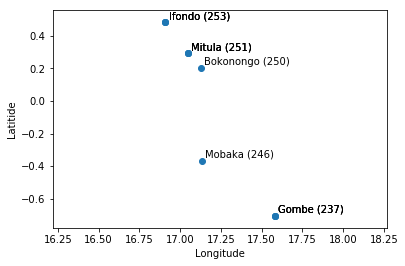

In [11]:
x = df['x_long']
y = df['y_lat']
n = df['ort']

fig, ax = plt.subplots()
plt.scatter(x, y)
for i, txt in enumerate(n):
    ax.annotate(txt, (x[i]+.02,y[i]+.02))
plt.xlabel("Longitude")
plt.ylabel("Latitide")
plt.axis('equal')
plt.show()

In [12]:
a = df.ix[df['ort_kurz'] == 'GMB'].values
pd.DataFrame(a)

,0,1,2,3,4,5,6,7,8,9
0,1830,GMB,Zaire/Kongo,237,Gombe (237),87/101,55,IMB/BDG (?),-0.704069,17.5804
1,6299,GMB,Zaire/Kongo,237,Gombe (237),87/101,"15, 25",IMB,-0.704069,17.5804
2,6300,GMB,Zaire/Kongo,237,Gombe (237),87/101,37,IMB (?),-0.704069,17.5804


In [13]:
a = df.ix[df['ort_kurz'] == 'IFN'].values
pd.DataFrame(a)

,0,1,2,3,4,5,6,7,8,9
0,1851,IFN,Sangha,253,Ifondo (253),87/101,9,IMB (?),0.481301,16.9088
1,4652,IFN,Sangha,253,Ifondo (253),87/101,11,PKM/IMB (?),0.481301,16.9088
2,4653,IFN,Sangha,253,Ifondo (253),87/101,8,PKM/IMB (?),0.481301,16.9088


In [14]:
a = df.ix[df['ort_kurz'] == 'BOG'].values
pd.DataFrame(a)

,0,1,2,3,4,5,6,7,8,9
0,2161,BOG,Sangha,250,Bokonongo (250),87/102,"4, 21",IMB (?),0.201971,17.1294


## Tafeln

In [15]:
sql = """SELECT
           t_Ort.ort_kurz AS SITE,
           t_Komplex.bef_nr AS FEAT,
           t_Obj.Individuum AS IND,
           t_Obj.Typ,
           t_Obj.Form_Gef,
           t_Obj.Form_Rand,
           t_Obj.Form_Boden
       FROM (t_Ort INNER JOIN t_Komplex ON t_Ort.ortID = t_Komplex.ortID)
           INNER JOIN t_Obj ON t_Komplex.komplexID = t_Obj.komplexID
       WHERE (((t_Ort.ort_lit) = 'DS')
           AND ((t_Obj.Typ) Like '%"""+style+"""%'))""".replace('\n',' ')

df = pd.read_sql(sql, con)

pl = pd.read_csv('../plates/plates.csv')

df_merge = pd.merge(pl, df, on=['SITE', 'FEAT', 'IND'], how='inner')
df_merge

,TAF,OBJ,SITE,FEAT,NOTE,IND,Typ,Form_Gef,Form_Rand,Form_Boden
0,33,2,GMB,87/101,NaN,55,IMB/BDG (?),None,B3,B12 (?)
1,33,4,GMB,87/101,NaN,"15, 25",IMB,A2/A3,None,None
2,39,5,MKA,87/102,NaN,1,IMB,C1 (?),None,None
3,41,3,BOG,87/102,NaN,"4, 21",IMB (?),None,None,None
4,41,15,MIT,87/101,NaN,11,IMB (?),C1 (?),None,None
5,41,16,MIT,87/101,NaN,1,IMB,C1 (?),None,None
6,42,10,MIT,87/103,NaN,1,IMB,C1,None,None
